# Cross-Validation and scoring methods

In [1]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

iris = load_iris()
X, y = iris.data, iris.target

classifier = KNeighborsClassifier()

The labels in iris are sorted, which means that if we split the data, the first fold will only have the label 0 in it, while the last one will only have the label 2:

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

To avoid this problem in evaluation, we first shuffle our data:

In [3]:
import numpy as np
rng = np.random.RandomState(0)

permutation = rng.permutation(len(X))
X, y = X[permutation], y[permutation]
print(y)

[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1
 2 0]


In [4]:
k = 5
n_samples = len(X)
fold_size = n_samples // k
scores = []
masks = []
for fold in range(k):
    # generate a boolean mask for the test set in this fold
    test_mask = np.zeros(n_samples, dtype=bool)
    test_mask[fold * fold_size : (fold + 1) * fold_size] = True
    # store the mask for visualization
    masks.append(test_mask)
    # create training and test sets using this mask
    X_test, y_test = X[test_mask], y[test_mask]
    X_train, y_train = X[~test_mask], y[~test_mask]
    # fit the classifier
    classifier.fit(X_train, y_train)
    # compute the score and record it
    scores.append(classifier.score(X_test, y_test))

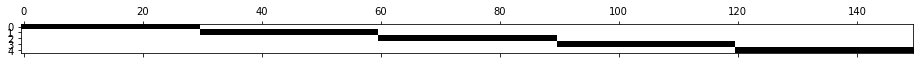

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(masks, cmap='gray_r')

In [6]:
print(scores)
print(np.mean(scores))

[0.9666666666666667, 0.9, 1.0, 1.0, 0.9333333333333333]
0.96


As you can see, there is a rather wide spectrum of scores from 90% correct to 100% correct. If we only did a single split, we might have gotten either answer.

As cross-validation is such a common pattern in machine learning, there are functions to do the above for you with much more flexibility and less code. The `sklearn.model_selection` module has all functions related to cross validation. There easiest function is `cross_val_score` which takes an estimator and a dataset, and will do all of the splitting for you:

In [7]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X, y)
print(scores)
print(np.mean(scores))

[1.         0.93333333 1.         1.         0.93333333]
0.9733333333333334


In [8]:
cross_val_score(classifier, X, y, cv=5)

array([1.        , 0.93333333, 1.        , 1.        , 0.93333333])

In [9]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

By default, cross_val_score will use `StratifiedKFold` for classification, which ensures that the class proportions in the dataset are reflected in each fold. If you have a binary classification dataset with 90% of data point belonging to class 0, that would mean that in each fold, 90% of datapoints would belong to class 0. If you would just use `KFold` cross-validation, it is likely that you would generate a split that only contains class 0. It is generally a good idea to use `StratifiedKFold` whenever you do classification.

StratifiedKFold would also remove our need to shuffle iris. Let's see what kinds of folds it generates on the unshuffled iris dataset. Each cross-validation class is a generator of sets of training and test indices:

In [10]:
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')

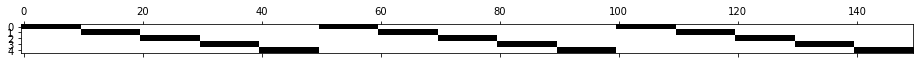

In [12]:
plot_cv(StratifiedKFold(n_splits=5), iris.data, iris.target)

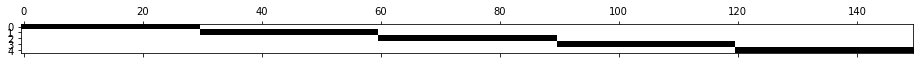

In [13]:
plot_cv(KFold(n_splits=5), iris.data, iris.target)

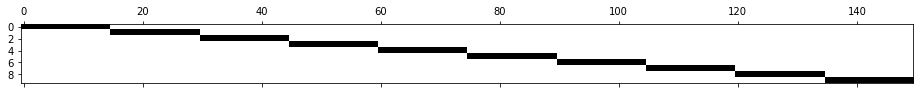

In [14]:
plot_cv(KFold(n_splits=10), iris.data, iris.target)


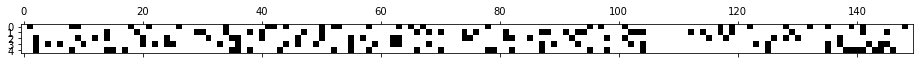

In [16]:
plot_cv(ShuffleSplit(n_splits=5, test_size=.2), iris.data, iris.target)

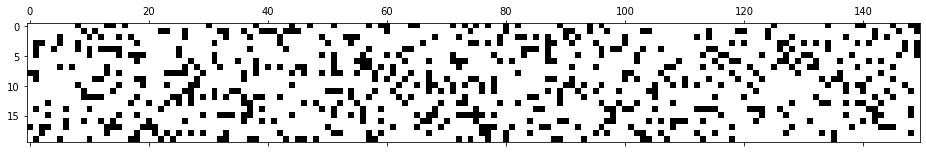

In [17]:
plot_cv(ShuffleSplit(n_splits=20, test_size=.2), iris.data, iris.target)

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=.2)
cross_val_score(classifier, X, y, cv=cv)

array([0.93333333, 1.        , 0.93333333, 0.96666667, 0.96666667])

<div class="alert alert-success">
    <b>EXERCISE</b>
    <ul>
    <li>
      Perform three-fold cross-validation using the `KFold` class on the iris dataset without shuffling the data. Can you explain the result?
    </li>
  </ul>
</div>